## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty, Trigger, TriggerRequest


In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [7]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [8]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.5):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [9]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [10]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [11]:

rospy.init_node("recognition")


In [12]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [13]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [14]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [15]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [16]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
    
# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node
def move_base(goal_x,goal_y,goal_yaw,time_out=10):
    pose = PoseStamped()
    pose.header.stamp = rospy.Time.now()
    pose.header.frame_id = "map"
    pose.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    pose.pose.orientation = Quaternion(*quat)


    # create a MOVE BASE GOAL
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result(timeout=rospy.Duration(time_out))

    # print result of navigation
    action_state = navclient.get_state()
    return navclient.get_state()

In [17]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [18]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [19]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz),images)
        

In [20]:
move_base(1.25,1.3,0.5*np.pi)

0

In [21]:
arm.set_named_target('go')
arm.go()
head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

In [22]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = -1.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 3  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = False    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE



In [23]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

_path_model = "/home/oscar/Codes/catkin_mio_ws/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()


In [45]:
path='/home/oscar/Videos/videos_to_keras_train/'
obj_ind=49

obj_name = ''.join(objs[obj_ind].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
delete_object('spawned')

In [29]:
move_base(1.25,1.0,np.pi)
gaze_point(1.25,1.71,.6)

('i am at', [1.3097212165378982, 0.9790564028761743, 1.0170716982631365], -179.41019992901892)
('gaze goal', 1.25, 1.71, 0.6)
('relative to robot', (0.05972121653789819, -0.7309435971238256, -85.32906519277725))


True

In [44]:

x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.41,eu_i,eu_j,eu_k )


[INFO] [1639496440.154362, 386.521000]: Spawn: ycb_040_large_marker
[INFO] [1639496440.156749, 386.534000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639496440.158624, 386.534000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496440.179911, 386.534000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496440.369291, 386.590000]: Spawn status: SpawnModel: Failure - entity already exists.


[INFO] [1639498795.331939, 854.806000]: Spawn: ycb_040_large_marker
[INFO] [1639498795.337710, 854.806000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639498795.344668, 854.806000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498795.364156, 854.820000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498795.409695, 854.832000]: Spawn status: SpawnModel: Failure - entity already exists.
('cX,cY', 373, 346)
[0.09225451 0.18039714 0.93832237]
53
[INFO] [1639498799.843164, 855.679000]: Spawn: ycb_040_large_marker
[INFO] [1639498799.847894, 855.679000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1639498799.850838, 855.679000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498799.866980, 855.679000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498800.053214, 855.700000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 374, 296)
[0.10499948 0.10456033 1.038348  ]
61
[INFO] [1639498804.951657

('cX,cY', 386, 299)
[0.12671812 0.11058772 1.0400358 ]
35
[INFO] [1639498872.479051, 866.913000]: Spawn: ycb_040_large_marker
[INFO] [1639498872.481353, 866.913000]: Spawn: [0.         0.         0.95579389 0.29403748]
[INFO] [1639498872.482988, 866.913000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498872.505797, 866.915000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498872.659847, 866.952000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 387, 298)
[0.12889238 0.10845691 1.0499724 ]
33
[INFO] [1639498876.339330, 867.538000]: Spawn: ycb_040_large_marker
[INFO] [1639498876.341659, 867.538000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1639498876.342827, 867.538000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498876.349297, 867.550000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498876.636696, 867.599000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 387, 304)
[0.12787972 0.11850853 1.0

('cX,cY', 397, 305)
[0.14355049 0.11855682 1.02667   ]
6
[INFO] [1639498946.848336, 878.551000]: Spawn: ycb_040_large_marker
[INFO] [1639498946.850399, 878.551000]: Spawn: [0.         0.         0.83580863 0.54902088]
[INFO] [1639498946.851396, 878.551000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498946.866392, 878.558000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498947.242354, 878.634000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 398, 301)
[0.1471668  0.11225822 1.0391217 ]
6
[INFO] [1639498951.597591, 879.302000]: Spawn: ycb_040_large_marker
[INFO] [1639498951.601258, 879.303000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1639498951.602896, 879.303000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498951.614100, 879.303000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498951.813691, 879.340000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 398, 301)
[0.14862907 0.11240411 1.042

('cX,cY', 401, 315)
[0.1459341  0.13399775 0.9925318 ]
36
[INFO] [1639499020.760168, 889.991000]: Spawn: ycb_040_large_marker
[INFO] [1639499020.763446, 889.991000]: Spawn: [0.         0.         0.64944931 0.76040489]
[INFO] [1639499020.764709, 889.992000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499020.771250, 889.993000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499020.836636, 889.996000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639499023.913739, 890.511000]: Spawn: ycb_040_large_marker
[INFO] [1639499023.915967, 890.511000]: Spawn: [0.         0.         0.63742524 0.77051221]
[INFO] [1639499023.919042, 890.511000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499023.925386, 890.511000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499024.202782, 890.550000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639499027.888421, 891.130000]: Spawn: ycb_040_large_marker
[INFO] [1639499027.890795, 891.13000

[INFO] [1639499092.277185, 901.165000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 398, 323)
[0.13919923 0.14591043 0.9767547 ]
10
[INFO] [1639499096.434742, 901.803000]: Spawn: ycb_040_large_marker
[INFO] [1639499096.438048, 901.804000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639499096.439344, 901.804000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499096.445360, 901.804000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499096.675550, 901.831000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639499099.976501, 902.363000]: Spawn: ycb_040_large_marker
[INFO] [1639499099.980431, 902.364000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1639499099.981763, 902.364000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499099.994391, 902.364000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499100.246137, 902.388000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 

[INFO] [1639499172.959805, 913.518000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639499176.480736, 913.989000]: Spawn: ycb_040_large_marker
[INFO] [1639499176.485316, 913.991000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1639499176.488648, 913.992000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499176.499574, 913.994000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499176.757096, 914.054000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639499180.465556, 914.611000]: Spawn: ycb_040_large_marker
[INFO] [1639499180.467894, 914.611000]: Spawn: [0.         0.         0.10973457 0.99396093]
[INFO] [1639499180.469191, 914.611000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499180.472881, 914.612000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499180.749838, 914.645000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639499185.125324, 915.246000]: Spawn: ycb_040_large_marker


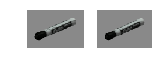

In [52]:
num_imgs=100
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.51,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    #res = service_client(req)
    #cents,xyz, images=res_to_cents(res)
    cents,xyz, images=seg_pca(lower=1000,higher=4000,plt_images=True)
    

    shapes_ratio=[]
   

    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    if len (images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

In [ ]:
num_imgs=100
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.53,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    res = service_client(req)
    cents,xyz, images=res_to_cents(res)
    shapes_ratio=[]
    
    
    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    if len(images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

[INFO] [1639434219.697308, 3813.229000]: Spawn: ycb_040_large_marker
[INFO] [1639434219.700051, 3813.229000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639434219.706843, 3813.229000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639434219.723896, 3813.231000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639434220.086576, 3813.252000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08416359, 0.18379717, 0.92941295])]
58
[INFO] [1639434228.933812, 3814.101000]: Spawn: ycb_040_large_marker
[INFO] [1639434228.940371, 3814.102000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1639434228.942337, 3814.102000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639434228.965386, 3814.102000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639434229.126474, 3814.116000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has',

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639434407.163180, 3829.351000]: Spawn: ycb_040_large_marker
[INFO] [1639434407.165300, 3829.351000]: Spawn: [0.         0.         0.96858393 0.2486869 ]
[INFO] [1639434407.168639, 3829.352000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639434407.183302, 3829.353000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639434407.459914, 3829.370000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639434420.382290, 3830.393000]: Spawn: ycb_040_large_marker
[INFO] [1639434420.384502, 3830.393000]: Spawn: [0.         0.         0.96455822 0.26387011]
[INFO] [1639434420.385992, 3830.393000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639434420.393548, 3830.393000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639434420.612334, 3830.414000]: Spawn status: SpawnModel: Successfully spawned entity


('Plane', 0, 'has', 2, 'objects')
('Plane', 1, 'has', 1, 'objects')
[array([-0.2772519 ,  0.23893867,  0.84951975]), array([0.10626701, 0.34888642, 0.86449317]), array([0.10603612, 0.09624477, 0.81212775])]


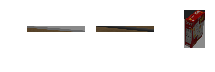

In [87]:

res = service_client(req)
cents,xyz, images=res_to_cents(res,plt_images=True)
#static_tf_publish(cents)
#move_base(1.1,1.3,np.pi)

In [88]:
shapes_ratio=[]
for image in images:
    print(np.abs(image.shape[0]-image.shape[1]))
    shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))

250
270
77


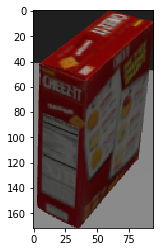

In [89]:
plt.imshow(images[np.argmin(shapes_ratio)])
contador=len(os.listdir(path+'/'+obj_name))
cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
delete_object('spawned')

('cX,cY', 147, 465)
[-0.2088794   0.45378765  1.1423471 ]
('cX,cY', 632, 463)
[0.671188   0.47392997 1.1998048 ]
('cX,cY', 300, 429)
[-0.08252022  0.3785833   1.1001376 ]
('cX,cY', 388, 302)
[0.11613703 0.10026138 0.9211477 ]
('cX,cY', 370, 120)
[ 0.36192173 -0.72074103  3.268955  ]
('cX,cY', 385, 42)
[ 0.41858223 -1.3087462   3.7992365 ]
('cX,cY', 26, 51)
[-1.6434754 -1.0098072  3.1469066]


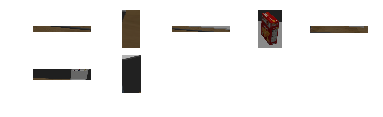

In [84]:
#cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)


In [65]:
arm.set_named_target('go')
arm.go()
head.set_named_targeta('neutral')
head.go()

AttributeError: 'MoveGroupCommander' object has no attribute 'set_named_targeta'

In [108]:
path='/home/oscar/Videos/videos_to_keras_train/'

objs[15].split('_')[1:]
obj_name = ''.join(objs[15].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  


[Errno 17] File exists: '/home/oscar/Videos/videos_to_keras_train/002masterchefcan'


True

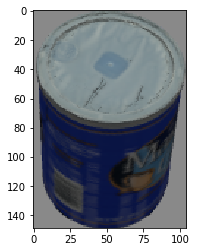

In [110]:
plt.imshow(images[0])
contador=len(os.listdir(path+'/'+obj_name))

cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [77]:

def pad_digit_num(num,length):
    text_num=''
    for i in range(length -len(str(num))):
        text_num=text_num+'0'
    return(text_num+str(num))


In [79]:
contador=len(os.listdir(path+'/'+obj_name))
x_gaz,y_gaz= world_2_gazebo(1.5,1.61)
eu_i,eu_j,eu_k = 2,0.0,0.0
spawn_object('spawned',objs[15], x_gaz,  y_gaz,  0.51,eu_i,eu_j,eu_k )

cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
delete_object('spawned')

[INFO] [1639176405.867521, 382.221000]: Spawn: ycb_002_master_chef_can
[INFO] [1639176405.871339, 382.221000]: Spawn: [0.         0.         0.84147098 0.54030231]
[INFO] [1639176405.877488, 382.221000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639176405.892504, 382.235000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639176406.261470, 382.287000]: Spawn status: SpawnModel: Successfully spawned entity


[array([-0.48997826,  0.47688341, -0.33030321,  0.65069448]),
 array([-0.16005207, -0.64494008, -0.18783798,  0.72329283]),
 array([-0.40752737,  0.91122733, -0.05654474,  0.01972043])]

In [26]:
#cents, xyz=seg_pca()
#quats= pca_xyz(xyz)

cents= objs_depth_centroids
static_tf_publish(cents,quats)

NameError: name 'objs_depth_centroids' is not defined

In [76]:
centroids,xyz, images=seg_pca()
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats)

('cX,cY', 73, 470)
[-0.38657558  0.40541616  0.98836577]
('cX,cY', 208, 439)
[-0.20475249  0.3305767   0.910819  ]
('cX,cY', 545, 430)
[0.46011162 0.37007445 1.1287674 ]
('cX,cY', 318, 326)
[-0.00164222  0.09490793  0.608489  ]
('cX,cY', 344, 50)
[ 0.15221651 -1.0081769   2.898817  ]
('cX,cY', 520, 9)
[ 1.2383422 -1.4023637  3.4012706]
('images[]', 0)
('images[]', 1)
('images[]', 2)
('images[]', 4)
('images[]', 5)


True

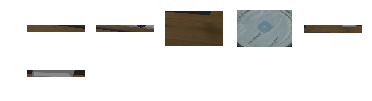

In [77]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

In [113]:
delete_object('spawned')

In [ ]:
tf.transformations.quaternion_from_euler(eu_i,eu_j,eu_k)

In [67]:
gaze_point( 1.45,1.7,  0.51)
arm.set_named_target('go')
arm.go()

('i am at', [1.504013154042386, 1.0881122082471295, 0.9671971453120808], 91.18959144177308)
('gaze goal', 1.45, 1.7, 0.51)
('relative to robot', (0.05401315404238605, -0.6118877917528704, -84.95540681911935))


True

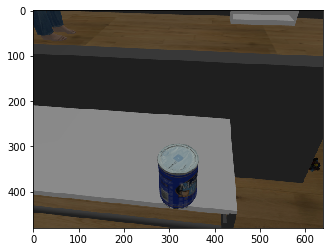

In [68]:
plt.imshow (rgbd.get_image())

('cX,cY', 76, 470)
[-0.3889382   0.40851146  0.9961041 ]
('cX,cY', 208, 438)
[-0.20423812  0.32901195  0.9134121 ]
('cX,cY', 545, 430)
[0.46086848 0.36852357 1.1306168 ]
('cX,cY', 319, 325)
[-5.3649477e-04  9.3556471e-02  6.1028546e-01]
('cX,cY', 302, 237)
[0.02285562 0.02727817 0.94996685]
('cX,cY', 343, 50)
[ 0.15232696 -1.0072949   2.8953772 ]
('cX,cY', 518, 8)
[ 1.2572143 -1.4013929  3.398889 ]


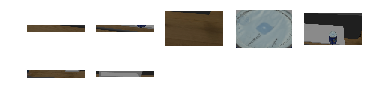

In [70]:
cents,xyz,images=seg_pca(lower=1000,higher=500000,plt_images=True)

In [71]:
res = service_client(req)

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 1, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([3.56465416e-05, 1.00570345e-01, 6.18601648e-01]), array([-0.14591429,  0.28734213,  0.73829112])]


(array([[ 3.56465416e-05,  1.00570345e-01,  6.18601648e-01],
        [-1.45914289e-01,  2.87342130e-01,  7.38291115e-01]]),
 array([array([[-0.00875298,  0.06010379,  0.64700001],
        [-0.00641885,  0.06010379,  0.64700001],
        [-0.00873945,  0.06117615,  0.64600003],
        ...,
        [ 0.04290358,  0.20726657,  0.67000002],
        [ 0.04450717,  0.2091227 ,  0.67600006],
        [ 0.04303165,  0.20909745,  0.67200005]]),
        array([[-0.44399658,  0.26528969,  0.76800001],
        [-0.44122592,  0.26528969,  0.76800001],
        [-0.44284034,  0.26598054,  0.76600003],
        ...,
        [ 0.12097691,  0.29648745,  0.69500005],
        [ 0.12115098,  0.29816949,  0.69600004],
        [ 0.12149911,  0.30028537,  0.69800001]])], dtype=object))

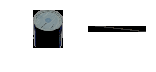

In [72]:
res_to_cents(res,plt_images=True)

In [53]:
path='/home/oscar/Videos/videos_to_keras_train/'
os.listdir(path)
objs[15].split('_')[1:]
obj_name = ''.join(objs[15].split('_')[1:])
obj_name

'002masterchefcan'

In [114]:
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',img_roi)

[Errno 17] File exists: '/home/oscar/Videos/videos_to_keras_train/002masterchefcan'


NameError: name 'img_roi' is not defined

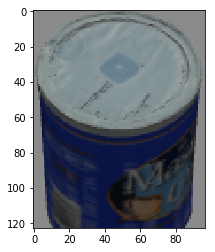

In [101]:
plt.imshow(images[0])

In [74]:
res_to_cents(res)

('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.45296013, -0.04971411,  0.96959864]), array([-4.17267404e-05,  1.00913426e-01,  6.18089280e-01]), array([-0.14664006,  0.28748951,  0.73805637])]


(array([[ 4.52960134e-01, -4.97141067e-02,  9.69598645e-01],
        [-4.17267404e-05,  1.00913426e-01,  6.18089280e-01],
        [-1.46640063e-01,  2.87489507e-01,  7.38056373e-01]]),
 array([array([[ 0.41473159, -0.07013206,  0.96000004],
        [ 0.4177593 , -0.07005901,  0.95900005],
        [ 0.41516361, -0.06847166,  0.96100003],
        ...,
        [ 0.49080631, -0.03260293,  0.97700006],
        [ 0.49130866, -0.03087218,  0.97800004],
        [ 0.49181104, -0.02913782,  0.97900003]]),
        array([[-0.00758592,  0.06010379,  0.64700001],
        [-0.00525179,  0.06010379,  0.64700001],
        [-0.00757419,  0.06117615,  0.64600003],
        ...,
        [ 0.04290358,  0.20726657,  0.67000002],
        [ 0.04450717,  0.2091227 ,  0.67600006],
        [ 0.04303165,  0.20909745,  0.67200005]]),
        array([[-0.44399658,  0.26528969,  0.76800001],
        [-0.44122592,  0.26528969,  0.76800001],
        [-0.44284034,  0.26598054,  0.76600003],
        ...,
        [ 0.1208

('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.45296013, -0.04971411,  0.96959864]), array([-4.17267404e-05,  1.00913426e-01,  6.18089280e-01]), array([-0.14664006,  0.28748951,  0.73805637])]


ValueError: need more than 2 values to unpack

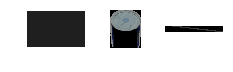

In [75]:
cents, xyz,images=res_to_cents(res,True)

In [ ]:
quats=pca_xyz(xyz)

In [ ]:
static_tf_publish(cents,quats,'end')

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
move_base(2,1,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
x_gaz,y_gaz= world_2_gazebo(1,1)
eu_i,eu_j,eu_k = .5*np.pi,0,0
spawn_object('spawned',objs[-13], x_gaz,  y_gaz,  0.6,eu_i,eu_j,eu_k )


In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 2,1')

In [ ]:
move_base(1.5,.5,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 1.5,.5')

In [ ]:
move_base(1.5,.5,0)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

('cX,cY', 301, 476)
[-0.00747844  0.21911964  0.5158296 ]
('cX,cY', 75, 468)
[-0.35996425  0.37436187  0.92190623]
('cX,cY', 290, 444)
[-0.16598909  0.35188416  0.93478006]
('cX,cY', 443, 285)
[0.14822534 0.00063732 0.6164476 ]
('cX,cY', 411, 326)
nan
('cX,cY', 454, 232)


/home/oscar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.
/home/oscar/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 0.20696914 -0.04515864  0.6708069 ]
('cX,cY', 613, 1)
[ 1.4960889 -1.2877432  3.0058494]
('cX,cY', 105, 3)
[-1.0369995 -1.1491358  2.699405 ]
('cX,cY', 17, 5)
[-1.5290263 -1.1761056  2.8287847]


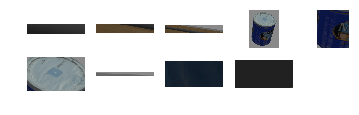

In [147]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)



('cX,cY', 374, 343)
[0.09510433 0.17500947 0.94141465]


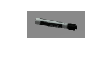

In [41]:
cents,xyz, images=seg_pca(lower=1000,higher=4000,plt_images=True)